# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Package Installation

In [ ]:
pip uninstall torch torchtext transformers -y

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: transformers 4.47.1
Uninstalling transformers-4.47.1:
  Successfully uninstalled transformers-4.47.1


In [ ]:
pip install torch==2.2.0 torchtext==0.17.0 transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5

## Import the libraries

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/TMSA')

In [ ]:
import torch
import torchtext
import transformers
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
from pathlib import Path
import sys
import os

# Logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"torchtext version: {torchtext.__version__}")
print(f"transformers version: {transformers.__version__}")

# Add project root to path
sys.path.append('/content')

# Import project components
from data.data_loader import DataLoader
from data.data_processor import DataProcessor
from models.lstm import LSTMClassifier
from models.bilstm import BiLSTMClassifier
from models.bert import BERTClassifier
from models.roberta import RoBERTaClassifier
from training.train import train_model
from training.evaluate import evaluate_model, plot_training_history
from knowledge_graph.graph_builder import KnowledgeGraphBuilder
from knowledge_graph.visualizer import KnowledgeGraphVisualizer
from utils.helpers import set_seed, get_device, setup_logging, create_experiment_dir
from config.model_config import *

PyTorch version: 2.2.0+cu121
torchtext version: 0.17.0+cpu
transformers version: 4.37.2


## Setup Logging and Directory

In [ ]:
exp_dir = create_experiment_dir('experiments', 'relation_classification')
setup_logging(exp_dir)

# Set random seed
set_seed(42)

# Get device
device = get_device()
logging.info(f"Using device: {device}")

2025-01-26 16:44:15,555 [INFO] Using device: cuda


# Data Loading and Preprocessing

In [ ]:
# Define file paths
file_paths = {
    'date_of_birth': '/content/drive/MyDrive/TMSA/dataset/date_of_birth.json',
    'education': '/content/drive/MyDrive/TMSA/dataset/education.json',
    'place_of_death': '/content/drive/MyDrive/TMSA/dataset/place_of_death.json',
    'place_of_birth': '/content/drive/MyDrive/TMSA/dataset/place_of_birth.json',
    'institution': '/content/drive/MyDrive/TMSA/dataset/institution.json'
}

# Define relation mapping
pred_mapping = {
    '/people/person/education./education/education/institution': 'institution',
    '/people/person/date_of_birth': 'date_of_birth',
    '/people/person/education./education/education/degree': 'degree',
    '/people/deceased_person/place_of_death': 'place_of_death',
    '/people/person/place_of_birth': 'place_of_birth'
}

try:
    # Load and process data
    logging.info("Loading and processing data...")
    data_loader = DataLoader(file_paths, pred_mapping)
    data_loader.load_all_data()
    data_loader.process_data()
    data_loader.balance_data()
    sentences, labels = data_loader.get_features_labels()
    logging.info("Data processing completed")
except Exception as e:
    logging.error(f"Error during data processing: {e}")
    raise

2025-01-26 16:44:15,565 [INFO] Loading and processing data...
2025-01-26 16:44:22,606 [INFO] Data processing completed


# Data Preparation

In [ ]:
# Initialize data processor
data_processor = DataProcessor()

# Data Preparation
try:
    logging.info("Preparing data splits...")
    split_data = data_processor.prepare_sequence_data(sentences, labels)

    # Create dataloaders for sequence models
    lstm_train_loader, lstm_val_loader, lstm_test_loader = \
        data_processor.create_sequence_dataloaders(split_data, batch_size=LSTM_CONFIG['batch_size'][0])

    # Create dataloaders for BERT
    bert_train_loader, bert_val_loader, bert_test_loader = \
        data_processor.create_transformer_dataloaders(
            split_data, model_name='bert-base-uncased', batch_size=BERT_CONFIG['batch_size'][0]
        )

    # Create dataloaders for RoBERTa
    roberta_train_loader, roberta_val_loader, roberta_test_loader = \
        data_processor.create_transformer_dataloaders(
            split_data, model_name='roberta-base', batch_size=ROBERTA_CONFIG['batch_size'][0]
        )

    # Function to recursively move data to device
    def to_device(batch, device):
        if isinstance(batch, (tuple, list)):
            return type(batch)(to_device(x, device) for x in batch)
        return batch.to(device) if hasattr(batch, 'to') else batch

    # Wrapping DataLoaders to ensure data moves to the correct device
    class DeviceDataLoader:
        def __init__(self, dataloader, device):
            self.dataloader = dataloader
            self.device = device
            self.batch_size = dataloader.batch_size

        def __iter__(self):
            for batch in self.dataloader:
                if isinstance(batch, (tuple, list)):
                    yield tuple(b.to(self.device) for b in batch)
                else:
                    yield batch.to(self.device)

        def __len__(self):
            return len(self.dataloader)

    # Wrap LSTM dataloaders
    lstm_train_loader = DeviceDataLoader(lstm_train_loader, device)
    lstm_val_loader = DeviceDataLoader(lstm_val_loader, device)
    lstm_test_loader = DeviceDataLoader(lstm_test_loader, device)

    # Wrap BERT dataloaders
    bert_train_loader = DeviceDataLoader(bert_train_loader, device)
    bert_val_loader = DeviceDataLoader(bert_val_loader, device)
    bert_test_loader = DeviceDataLoader(bert_test_loader, device)

    # Wrap RoBERTa dataloaders
    roberta_train_loader = DeviceDataLoader(roberta_train_loader, device)
    roberta_val_loader = DeviceDataLoader(roberta_val_loader, device)
    roberta_test_loader = DeviceDataLoader(roberta_test_loader, device)

    logging.info("Data preparation completed")
except Exception as e:
    logging.error(f"Error during data preparation: {e}")
    raise

2025-01-26 16:44:22,639 [INFO] Preparing data splits...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2025-01-26 16:44:37,051 [INFO] Data preparation completed


In [ ]:
# Data Inspection
data_loader.process_data()
processed_df = pd.DataFrame(data_loader.processed_data)
logging.info("\nFirst few rows of processed data:")
logging.info("\n" + str(processed_df.head(10)))

2025-01-26 16:44:37,485 [INFO] 
First few rows of processed data:
2025-01-26 16:44:37,500 [INFO] 
        relation                         subject      object  \
0  date_of_birth                James Cunningham        1973   
1  date_of_birth                     Kepookalani        1760   
2  date_of_birth           Shamsher M. Chowdhury        1950   
3  date_of_birth                      Gary Sykes  1984-02-13   
4  date_of_birth                Carolus Hacquart        1640   
5  date_of_birth              Hollister brothers  1923-07-06   
6  date_of_birth        Francisco Gil de Taboada        1736   
7  date_of_birth                  Nasser Sharify        1925   
8  date_of_birth  Wineville Chicken Coop Murders        1906   
9  date_of_birth             Clayton Jacobson II        1932   

                                           evidences  
0  [{'url': 'http://en.wikipedia.org/wiki/James_C...  
1  [{'url': 'http://en.wikipedia.org/wiki/Kepooka...  
2  [{'url': 'http://en.wikipedia

## Class Weight Calculation

In [ ]:
if TRAIN_PARAMS['class_weights']:
    from collections import Counter
    class_counts = Counter(labels)
    total = len(labels)
    class_weights = {label: total/(len(class_counts) * count) for label, count in class_counts.items()}
    class_weights = torch.FloatTensor(list(class_weights.values())).to(device)
else:
    class_weights = None

# Model Training and Evaluation

## LSTM Model


Training lstm_e256_h256_l2_d0.5_lr0.0001 with configuration:
Learning Rate: 0.0001
Batch Size: 64
Hidden Dimension: 256
Embedding Dimension: 256
Number of Layers: 2
Dropout: 0.5
Number of Epochs: 20


Epoch 1/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 20.70it/s]


Train Loss: 1.6632, Train Acc: 0.2525, Val Loss: 1.5522, Val Acc: 0.3405


Epoch 2/20: 100%|█████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.02it/s]


Train Loss: 1.5542, Train Acc: 0.3159, Val Loss: 1.5201, Val Acc: 0.3751


Epoch 3/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.68it/s]


Train Loss: 1.4810, Train Acc: 0.3696, Val Loss: 1.4967, Val Acc: 0.3805


Epoch 4/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.98it/s]


Train Loss: 1.4058, Train Acc: 0.4015, Val Loss: 1.4297, Val Acc: 0.4097


Epoch 5/20: 100%|█████████████████████████████████████████████████| 102/102 [00:05<00:00, 18.51it/s]


Train Loss: 1.2677, Train Acc: 0.4600, Val Loss: 1.2760, Val Acc: 0.5092


Epoch 6/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.78it/s]


Train Loss: 1.0646, Train Acc: 0.5633, Val Loss: 0.9946, Val Acc: 0.5773


Epoch 7/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 20.49it/s]


Train Loss: 0.9318, Train Acc: 0.6066, Val Loss: 0.9372, Val Acc: 0.6141


Epoch 8/20: 100%|█████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.03it/s]


Train Loss: 0.8671, Train Acc: 0.6347, Val Loss: 0.8737, Val Acc: 0.6292


Epoch 9/20: 100%|█████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.71it/s]


Train Loss: 0.8152, Train Acc: 0.6486, Val Loss: 0.8309, Val Acc: 0.6422


Epoch 10/20: 100%|████████████████████████████████████████████████| 102/102 [00:06<00:00, 16.08it/s]


Train Loss: 0.7857, Train Acc: 0.6650, Val Loss: 1.0502, Val Acc: 0.6173


Epoch 11/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.54it/s]


Train Loss: 0.7569, Train Acc: 0.6810, Val Loss: 0.8110, Val Acc: 0.6659


Epoch 12/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.63it/s]


Train Loss: 0.6947, Train Acc: 0.7053, Val Loss: 0.8257, Val Acc: 0.6757


Epoch 13/20: 100%|████████████████████████████████████████████████| 102/102 [00:05<00:00, 18.36it/s]


Train Loss: 0.6558, Train Acc: 0.7264, Val Loss: 0.8217, Val Acc: 0.6854


Epoch 14/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.58it/s]


Train Loss: 0.6388, Train Acc: 0.7376, Val Loss: 0.7565, Val Acc: 0.7027


Epoch 15/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.11it/s]


Train Loss: 0.6235, Train Acc: 0.7374, Val Loss: 0.7088, Val Acc: 0.7168


Epoch 16/20: 100%|████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.29it/s]


Train Loss: 0.5911, Train Acc: 0.7561, Val Loss: 0.6953, Val Acc: 0.7168


Epoch 17/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.86it/s]


Train Loss: 0.5909, Train Acc: 0.7533, Val Loss: 0.7447, Val Acc: 0.7070


Epoch 18/20: 100%|████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.61it/s]


Train Loss: 0.5679, Train Acc: 0.7661, Val Loss: 0.7120, Val Acc: 0.7124


Epoch 19/20: 100%|████████████████████████████████████████████████| 102/102 [00:05<00:00, 20.34it/s]


Train Loss: 0.5537, Train Acc: 0.7698, Val Loss: 0.6483, Val Acc: 0.7286


Epoch 20/20: 100%|████████████████████████████████████████████████| 102/102 [00:04<00:00, 21.77it/s]


Train Loss: 0.5363, Train Acc: 0.7776, Val Loss: 0.7391, Val Acc: 0.7081

Classification Report:
                precision    recall  f1-score   support

 date_of_birth       0.55      0.62      0.58       384
        degree       1.00      1.00      1.00       366
   institution       0.73      0.79      0.76       391
place_of_birth       0.47      0.34      0.39       352
place_of_death       0.91      0.93      0.92       358

      accuracy                           0.74      1851
     macro avg       0.73      0.74      0.73      1851
  weighted avg       0.73      0.74      0.73      1851



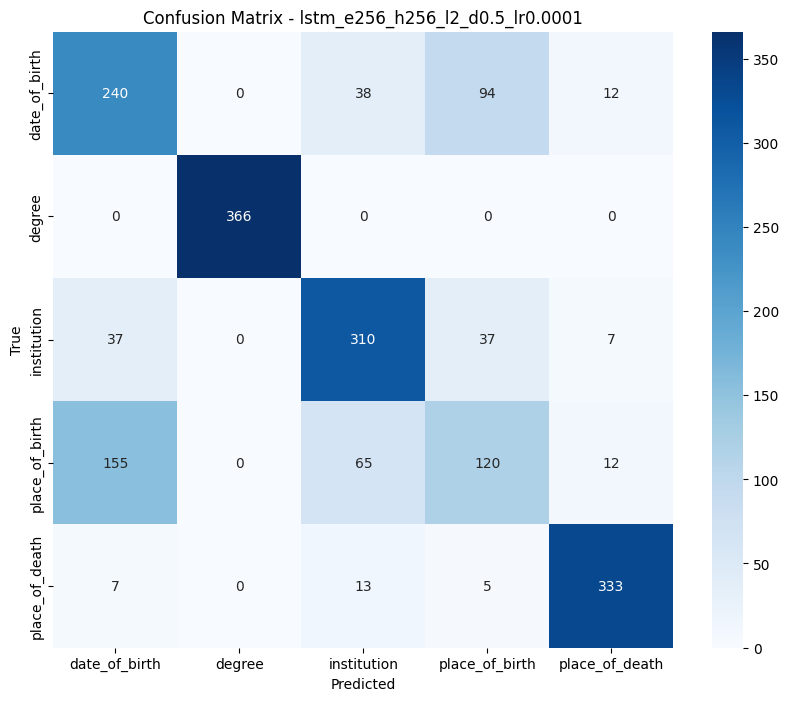

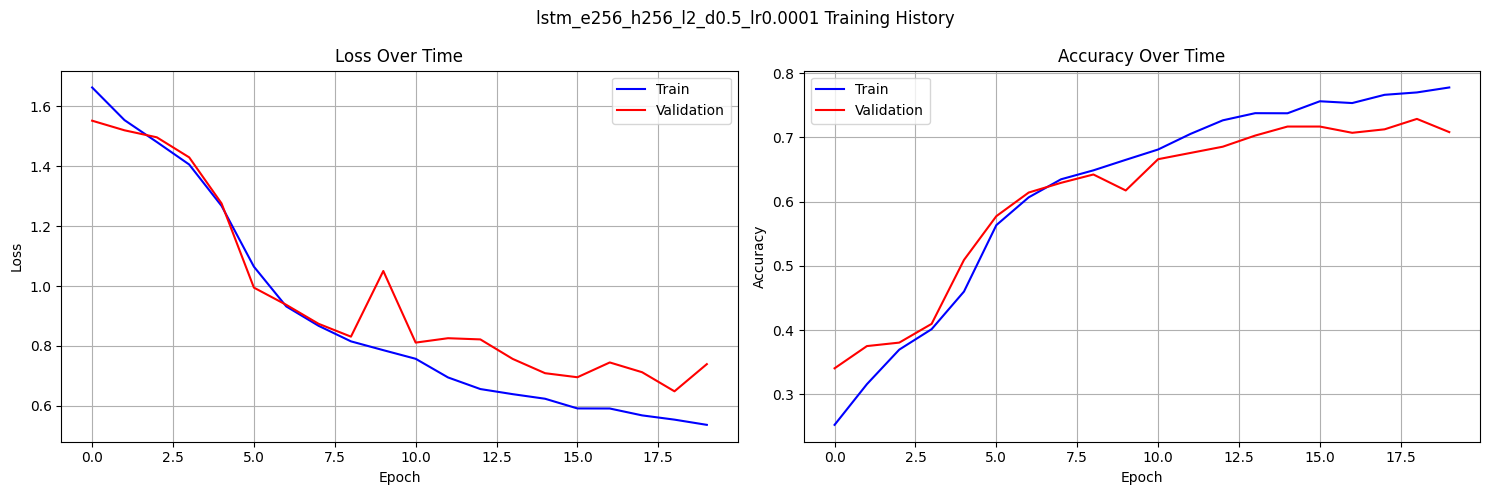

2025-01-26 16:47:49,545 [INFO] 
Classification Report:
2025-01-26 16:47:49,576 [INFO]                 precision    recall  f1-score   support

 date_of_birth       0.55      0.62      0.58       384
        degree       1.00      1.00      1.00       366
   institution       0.73      0.79      0.76       391
place_of_birth       0.47      0.34      0.39       352
place_of_death       0.91      0.93      0.92       358

      accuracy                           0.74      1851
     macro avg       0.73      0.74      0.73      1851
  weighted avg       0.73      0.74      0.73      1851

2025-01-26 16:47:51,581 [INFO] 
Final Training Metrics for lstm_e256_h256_l2_d0.5_lr0.0001:
2025-01-26 16:47:51,584 [INFO] Final Training Loss: 0.5363
2025-01-26 16:47:51,587 [INFO] Final Training Accuracy: 0.7776
2025-01-26 16:47:51,589 [INFO] Final Validation Loss: 0.7391
2025-01-26 16:47:51,591 [INFO] Final Validation Accuracy: 0.7081


In [ ]:
# LSTM Model Training
lstm_results = {}
best_lstm_model = None
best_lstm_acc = 0.0

for embedding_dim in LSTM_CONFIG['embedding_dim']:
    for hidden_dim in LSTM_CONFIG['hidden_dim']:
        for n_layers in LSTM_CONFIG['n_layers']:
            for dropout in LSTM_CONFIG['dropout']:
                for lr in LSTM_CONFIG['learning_rates']:
                    # Create unique model name for this configuration
                    model_name = f'lstm_e{embedding_dim}_h{hidden_dim}_l{n_layers}_d{dropout}_lr{lr}'

                    try:
                        # Initialize model
                        lstm_model = LSTMClassifier(
                            vocab_size=len(data_processor.vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            output_dim=len(data_processor.label2id),
                            pad_idx=data_processor.vocab['<pad>'],
                            n_layers=n_layers,
                            dropout=dropout
                        ).to(device)

                        # Train model
                        results = train_model(
                            model=lstm_model,
                            train_loader=lstm_train_loader,
                            val_loader=lstm_val_loader,
                            test_loader=lstm_test_loader,
                            learning_rate=lr,
                            num_epochs=LSTM_CONFIG['epochs'],
                            device=device,
                            model_name=model_name,
                            id2label=data_processor.id2label,
                            is_sequence_model=True,
                            save_dir=exp_dir,
                            monitor=TRAIN_PARAMS['monitor'],
                            class_weights=class_weights,
                            weight_decay=TRAIN_PARAMS['weight_decay']
                        )

                        # Evaluate model
                        metrics = evaluate_model(
                            model=lstm_model,
                            test_loader=lstm_test_loader,
                            device=device,
                            id2label=data_processor.id2label,
                            is_sequence_model=True
                        )

                        # Plot training history
                        plot_training_history(
                            results['history'],
                            exp_dir,
                            model_name
                        )

                        # Save results
                        lstm_results[model_name] = {
                            'config': {
                                'embedding_dim': embedding_dim,
                                'hidden_dim': hidden_dim,
                                'n_layers': n_layers,
                                'dropout': dropout,
                                'learning_rate': lr
                            },
                            'metrics': metrics,
                            'history': results['history']
                        }

                        # Update best model
                        if metrics['accuracy'] > best_lstm_acc:
                            best_lstm_acc = metrics['accuracy']
                            best_lstm_model = {
                                'name': model_name,
                                'config': lstm_results[model_name]['config'],
                                'metrics': metrics
                            }

                    except Exception as e:
                        logging.error(f"Error training LSTM configuration {model_name}: {str(e)}")
                        continue

## BiLSTM Model


Training bilstm_e256_h512_l2_d0.5_lr5e-05 with configuration:
Learning Rate: 5e-05
Batch Size: 64
Hidden Dimension: 512
Embedding Dimension: 256
Number of Layers: 2
Dropout: 0.5
Number of Epochs: 15


Epoch 1/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.14it/s]


Train Loss: 1.3867, Train Acc: 0.4194, Val Loss: 1.0676, Val Acc: 0.5589


Epoch 2/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.13it/s]


Train Loss: 0.9967, Train Acc: 0.6033, Val Loss: 0.7705, Val Acc: 0.6832


Epoch 3/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.17it/s]


Train Loss: 0.7903, Train Acc: 0.6759, Val Loss: 0.6345, Val Acc: 0.7276


Epoch 4/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.15it/s]


Train Loss: 0.6811, Train Acc: 0.7133, Val Loss: 0.5715, Val Acc: 0.7416


Epoch 5/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.13it/s]


Train Loss: 0.6152, Train Acc: 0.7416, Val Loss: 0.5381, Val Acc: 0.7546


Epoch 6/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.16it/s]


Train Loss: 0.5640, Train Acc: 0.7581, Val Loss: 0.5075, Val Acc: 0.7784


Epoch 7/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.16it/s]


Train Loss: 0.5286, Train Acc: 0.7868, Val Loss: 0.4884, Val Acc: 0.8000


Epoch 8/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.14it/s]


Train Loss: 0.4960, Train Acc: 0.7895, Val Loss: 0.4599, Val Acc: 0.7881


Epoch 9/15: 100%|█████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.16it/s]


Train Loss: 0.4831, Train Acc: 0.7970, Val Loss: 0.4552, Val Acc: 0.8054


Epoch 10/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.15it/s]


Train Loss: 0.4575, Train Acc: 0.8134, Val Loss: 0.4424, Val Acc: 0.8205


Epoch 11/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.13it/s]


Train Loss: 0.4526, Train Acc: 0.8129, Val Loss: 0.4273, Val Acc: 0.8205


Epoch 12/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.17it/s]


Train Loss: 0.4256, Train Acc: 0.8200, Val Loss: 0.4405, Val Acc: 0.8119


Epoch 13/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.12it/s]


Train Loss: 0.4087, Train Acc: 0.8327, Val Loss: 0.4235, Val Acc: 0.8141


Epoch 14/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.14it/s]


Train Loss: 0.3864, Train Acc: 0.8477, Val Loss: 0.4309, Val Acc: 0.8270


Epoch 15/15: 100%|████████████████████████████████████████████████| 102/102 [00:24<00:00,  4.14it/s]


Train Loss: 0.3621, Train Acc: 0.8539, Val Loss: 0.4024, Val Acc: 0.8292

Classification Report:
                precision    recall  f1-score   support

 date_of_birth       0.70      0.68      0.69       384
        degree       1.00      1.00      1.00       366
   institution       0.79      0.77      0.78       391
place_of_birth       0.62      0.66      0.64       352
place_of_death       0.93      0.92      0.93       358

      accuracy                           0.81      1851
     macro avg       0.81      0.81      0.81      1851
  weighted avg       0.81      0.81      0.81      1851



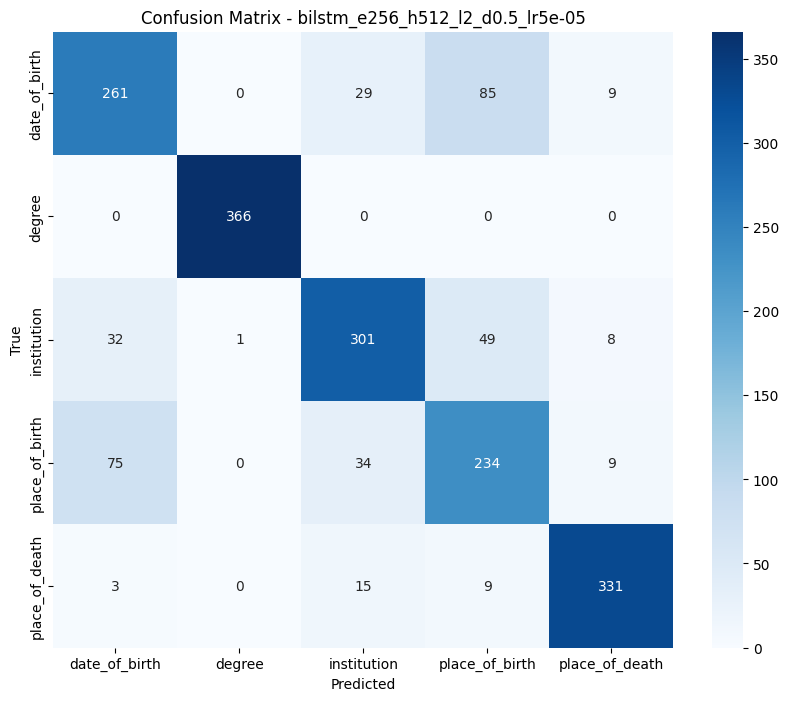

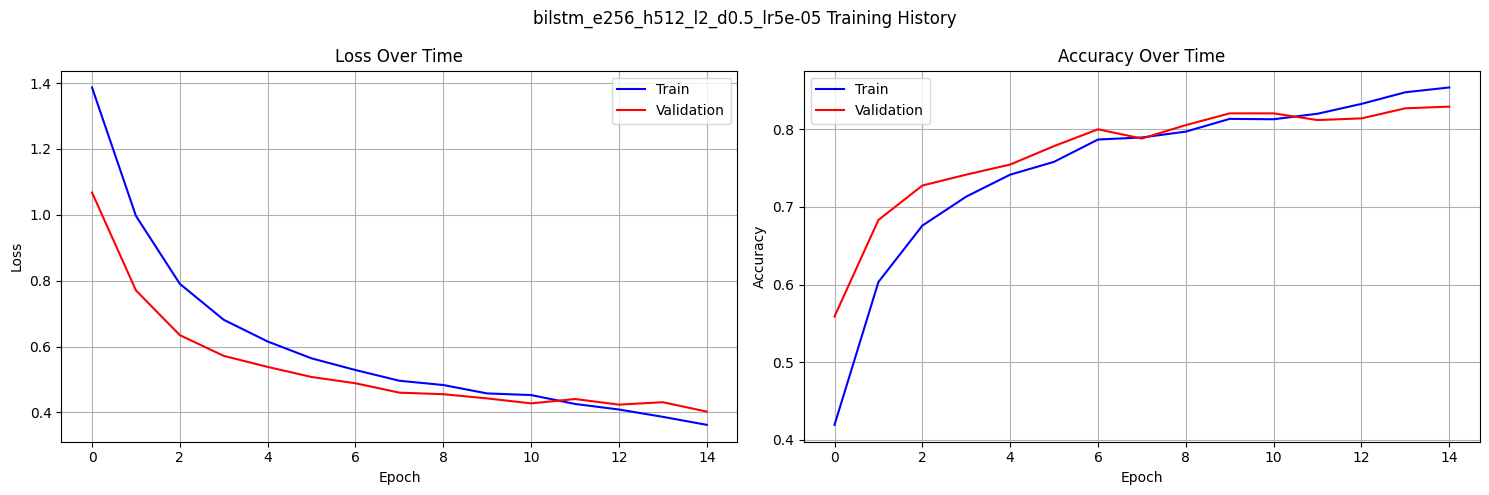

2025-01-26 16:54:19,835 [INFO] 
Classification Report:
2025-01-26 16:54:19,874 [INFO]                 precision    recall  f1-score   support

 date_of_birth       0.70      0.68      0.69       384
        degree       1.00      1.00      1.00       366
   institution       0.79      0.77      0.78       391
place_of_birth       0.62      0.66      0.64       352
place_of_death       0.93      0.92      0.93       358

      accuracy                           0.81      1851
     macro avg       0.81      0.81      0.81      1851
  weighted avg       0.81      0.81      0.81      1851

2025-01-26 16:54:21,460 [INFO] 
Final Training Metrics for bilstm_e256_h512_l2_d0.5_lr5e-05:
2025-01-26 16:54:21,466 [INFO] Final Training Loss: 0.3621
2025-01-26 16:54:21,470 [INFO] Final Training Accuracy: 0.8539
2025-01-26 16:54:21,473 [INFO] Final Validation Loss: 0.4024
2025-01-26 16:54:21,475 [INFO] Final Validation Accuracy: 0.8292


In [ ]:
# BiLSTM Model Training
bilstm_results = {}
best_bilstm_model = None
best_bilstm_acc = 0.0

for embedding_dim in BILSTM_CONFIG['embedding_dim']:
    for hidden_dim in BILSTM_CONFIG['hidden_dim']:
        for n_layers in BILSTM_CONFIG['n_layers']:
            for dropout in BILSTM_CONFIG['dropout']:
                for lr in BILSTM_CONFIG['learning_rates']:
                    # Create unique model name for this configuration
                    model_name = f'bilstm_e{embedding_dim}_h{hidden_dim}_l{n_layers}_d{dropout}_lr{lr}'

                    try:
                        # Initialize model
                        bilstm_model = BiLSTMClassifier(
                            vocab_size=len(data_processor.vocab),
                            embedding_dim=embedding_dim,
                            hidden_dim=hidden_dim,
                            output_dim=len(data_processor.label2id),
                            pad_idx=data_processor.vocab['<pad>'],
                            n_layers=n_layers,
                            dropout=dropout
                        ).to(device)

                        # Train model
                        results = train_model(
                            model=bilstm_model,
                            train_loader=lstm_train_loader,
                            val_loader=lstm_val_loader,
                            test_loader=lstm_test_loader,
                            learning_rate=lr,
                            num_epochs=BILSTM_CONFIG['epochs'],
                            device=device,
                            model_name=model_name,
                            id2label=data_processor.id2label,
                            is_sequence_model=True,
                            save_dir=exp_dir,
                            monitor=TRAIN_PARAMS['monitor'],
                            class_weights=class_weights,
                            weight_decay=TRAIN_PARAMS['weight_decay']
                        )

                        # Evaluate model
                        metrics = evaluate_model(
                            model=bilstm_model,
                            test_loader=lstm_test_loader,
                            device=device,
                            id2label=data_processor.id2label,
                            is_sequence_model=True
                        )

                        # Plot training history
                        plot_training_history(
                            results['history'],
                            exp_dir,
                            model_name
                        )

                        # Save results
                        bilstm_results[model_name] = {
                            'config': {
                                'embedding_dim': embedding_dim,
                                'hidden_dim': hidden_dim,
                                'n_layers': n_layers,
                                'dropout': dropout,
                                'learning_rate': lr
                            },
                            'metrics': metrics,
                            'history': results['history']
                        }

                        # Update best model
                        if metrics['accuracy'] > best_bilstm_acc:
                            best_bilstm_acc = metrics['accuracy']
                            best_bilstm_model = {
                                'name': model_name,
                                'config': bilstm_results[model_name]['config'],
                                'metrics': metrics
                            }

                    except Exception as e:
                        logging.error(f"Error training BiLSTM configuration {model_name}: {str(e)}")
                        continue

## BERT Model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Training bert_d0.4_lr1e-05 with configuration:
Learning Rate: 1e-05
Batch Size: 32
Dropout: 0.4
Number of Epochs: 5


Epoch 1/5: 100%|██████████████████████████████████████████████████| 203/203 [01:12<00:00,  2.81it/s]


Train Loss: 1.2556, Train Acc: 0.4705, Val Loss: 0.7228, Val Acc: 0.7373


Epoch 2/5: 100%|██████████████████████████████████████████████████| 203/203 [01:11<00:00,  2.83it/s]


Train Loss: 0.6261, Train Acc: 0.7858, Val Loss: 0.4339, Val Acc: 0.8357


Epoch 3/5: 100%|██████████████████████████████████████████████████| 203/203 [01:11<00:00,  2.82it/s]


Train Loss: 0.4536, Train Acc: 0.8445, Val Loss: 0.3897, Val Acc: 0.8486


Epoch 4/5: 100%|██████████████████████████████████████████████████| 203/203 [01:11<00:00,  2.82it/s]


Train Loss: 0.3829, Train Acc: 0.8653, Val Loss: 0.3979, Val Acc: 0.8476


Epoch 5/5: 100%|██████████████████████████████████████████████████| 203/203 [01:11<00:00,  2.83it/s]


Train Loss: 0.3326, Train Acc: 0.8789, Val Loss: 0.3666, Val Acc: 0.8595

Classification Report:
                precision    recall  f1-score   support

 date_of_birth       0.85      0.80      0.82       384
        degree       1.00      0.98      0.99       366
   institution       0.81      0.84      0.83       391
place_of_birth       0.73      0.78      0.75       352
place_of_death       0.92      0.91      0.92       358

      accuracy                           0.86      1851
     macro avg       0.86      0.86      0.86      1851
  weighted avg       0.86      0.86      0.86      1851



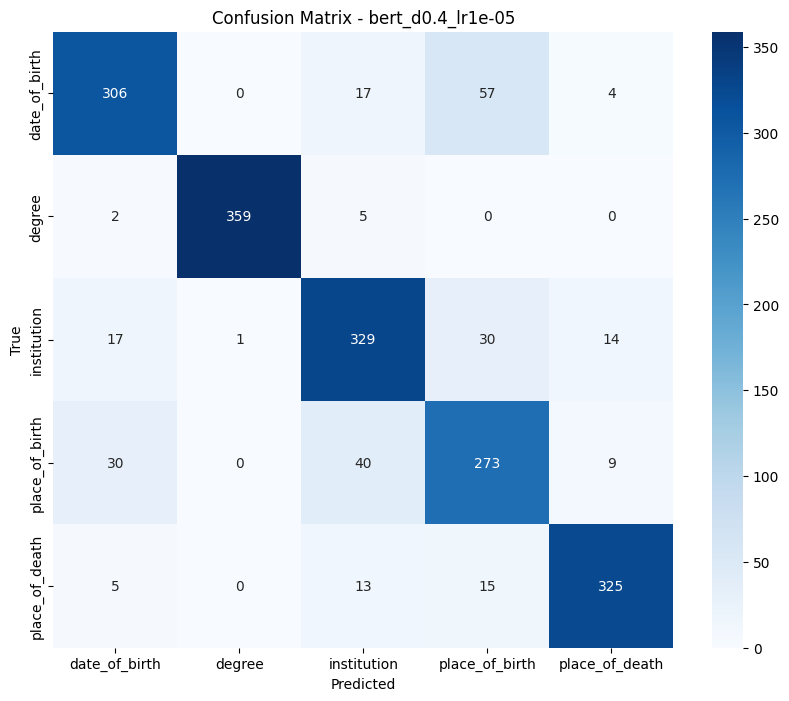

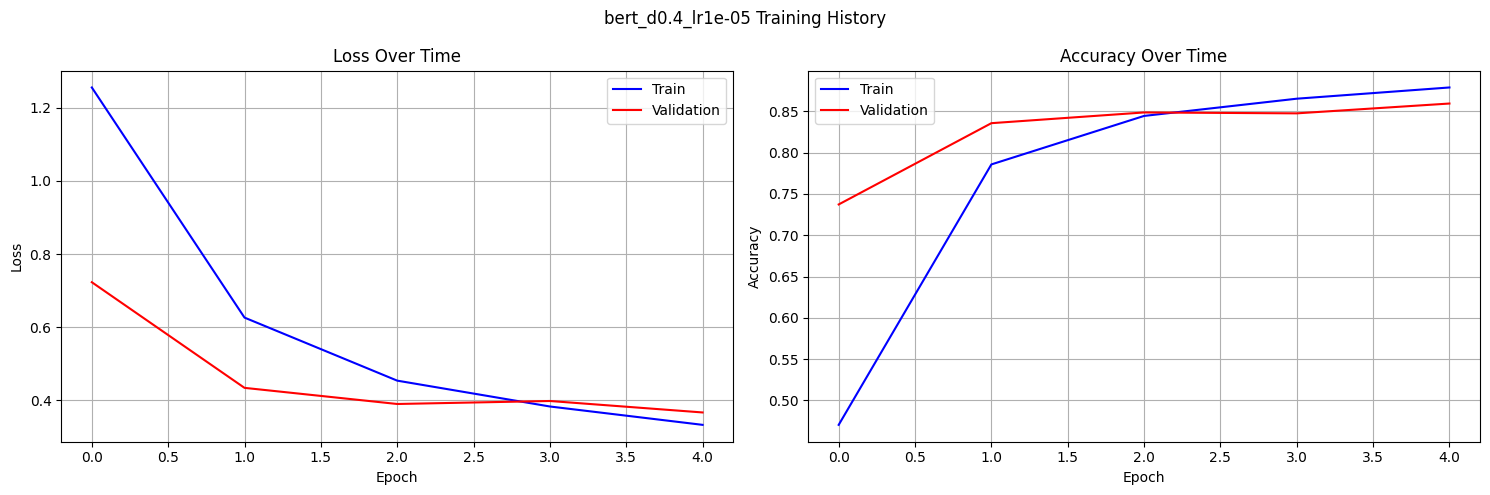

2025-01-26 17:01:23,154 [INFO] 
Classification Report:
2025-01-26 17:01:23,185 [INFO]                 precision    recall  f1-score   support

 date_of_birth       0.85      0.80      0.82       384
        degree       1.00      0.98      0.99       366
   institution       0.81      0.84      0.83       391
place_of_birth       0.73      0.78      0.75       352
place_of_death       0.92      0.91      0.92       358

      accuracy                           0.86      1851
     macro avg       0.86      0.86      0.86      1851
  weighted avg       0.86      0.86      0.86      1851

2025-01-26 17:01:25,139 [INFO] 
Final Training Metrics for bert_d0.4_lr1e-05:
2025-01-26 17:01:25,141 [INFO] Final Training Loss: 0.3326
2025-01-26 17:01:25,144 [INFO] Final Training Accuracy: 0.8789
2025-01-26 17:01:25,153 [INFO] Final Validation Loss: 0.3666
2025-01-26 17:01:25,155 [INFO] Final Validation Accuracy: 0.8595


In [ ]:
# BERT Model Training
bert_results = {}
best_bert_model = None
best_bert_acc = 0.0

for dropout in BERT_CONFIG['dropout']:
    for lr in BERT_CONFIG['learning_rates']:
        # Create unique model name for this configuration
        model_name = f'bert_d{dropout}_lr{lr}'

        try:
            # Initialize model
            bert_model = BERTClassifier(
                num_labels=len(data_processor.label2id),
                dropout=dropout
            ).to(device)

            # Train model
            results = train_model(
                model=bert_model,
                train_loader=bert_train_loader,
                val_loader=bert_val_loader,
                test_loader=bert_test_loader,
                learning_rate=lr,
                num_epochs=BERT_CONFIG['epochs'],
                device=device,
                model_name=model_name,
                id2label=data_processor.id2label,
                is_sequence_model=False,
                save_dir=exp_dir,
                monitor=TRAIN_PARAMS['monitor'],
                class_weights=class_weights,
                weight_decay=TRAIN_PARAMS['weight_decay'],
                warmup_steps=BERT_CONFIG['warmup_steps']
            )

            # Evaluate model
            metrics = evaluate_model(
                model=bert_model,
                test_loader=bert_test_loader,
                device=device,
                id2label=data_processor.id2label,
                is_sequence_model=False
            )

            # Plot training history
            plot_training_history(
                results['history'],
                exp_dir,
                model_name
            )

            # Save results
            bert_results[model_name] = {
                'config': {
                    'dropout': dropout,
                    'learning_rate': lr
                },
                'metrics': metrics,
                'history': results['history']
            }

            # Update best model
            if metrics['accuracy'] > best_bert_acc:
                best_bert_acc = metrics['accuracy']
                best_bert_model = {
                    'name': model_name,
                    'config': bert_results[model_name]['config'],
                    'metrics': metrics
                }

        except Exception as e:
            logging.error(f"Error training BERT configuration {model_name}: {str(e)}")
            continue

## RoBERTa Model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training roberta_d0.5_lr3e-06 with configuration:
Learning Rate: 3e-06
Batch Size: 16
Dropout: 0.5
Number of Epochs: 5


Epoch 1/5: 100%|██████████████████████████████████████████████████| 405/405 [02:25<00:00,  2.78it/s]


Train Loss: 1.0144, Train Acc: 0.5575, Val Loss: 0.4485, Val Acc: 0.8043


Epoch 2/5: 100%|██████████████████████████████████████████████████| 405/405 [02:25<00:00,  2.78it/s]


Train Loss: 0.4716, Train Acc: 0.8120, Val Loss: 0.3701, Val Acc: 0.8638


Epoch 3/5: 100%|██████████████████████████████████████████████████| 405/405 [02:25<00:00,  2.78it/s]


Train Loss: 0.3979, Train Acc: 0.8486, Val Loss: 0.3839, Val Acc: 0.8692


Epoch 4/5: 100%|██████████████████████████████████████████████████| 405/405 [02:25<00:00,  2.78it/s]


Train Loss: 0.3574, Train Acc: 0.8687, Val Loss: 0.3756, Val Acc: 0.8757


Epoch 5/5: 100%|██████████████████████████████████████████████████| 405/405 [02:25<00:00,  2.78it/s]


Train Loss: 0.3204, Train Acc: 0.8823, Val Loss: 0.3603, Val Acc: 0.8746

Classification Report:
                precision    recall  f1-score   support

 date_of_birth       0.89      0.72      0.79       384
        degree       1.00      0.98      0.99       366
   institution       0.78      0.89      0.83       391
place_of_birth       0.70      0.77      0.73       352
place_of_death       0.93      0.91      0.92       358

      accuracy                           0.85      1851
     macro avg       0.86      0.85      0.85      1851
  weighted avg       0.86      0.85      0.85      1851



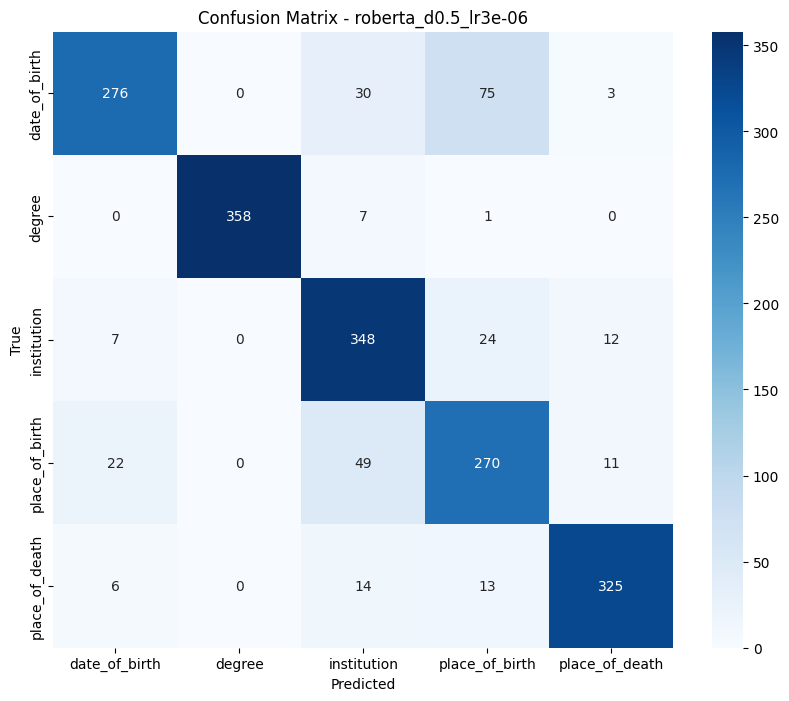

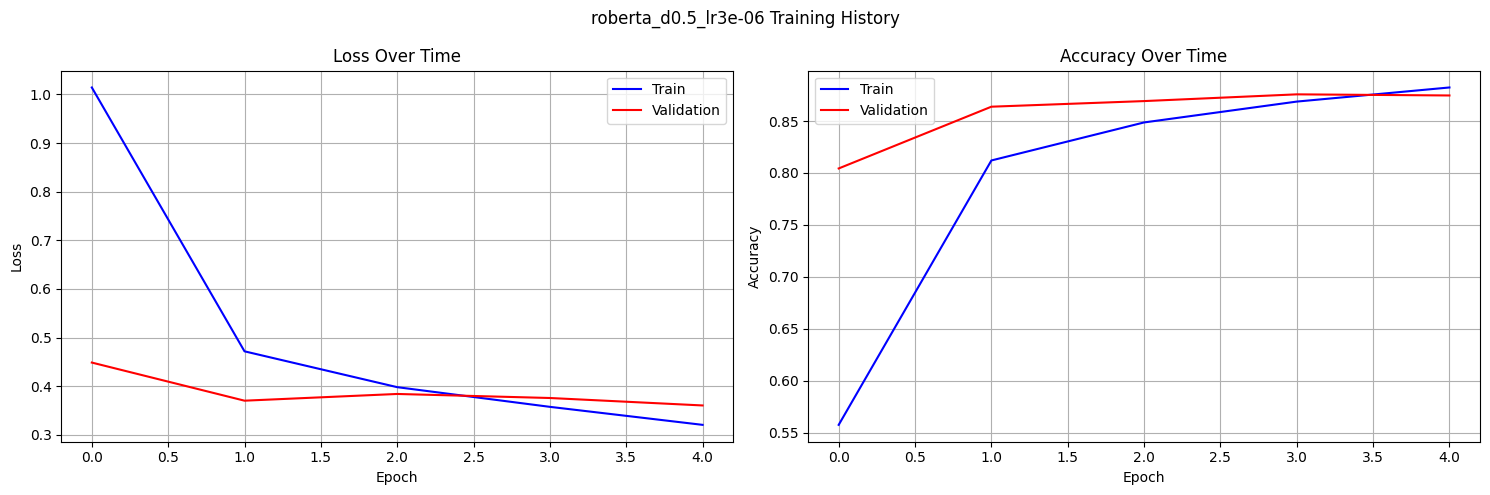

2025-01-26 17:14:37,956 [INFO] 
Classification Report:
2025-01-26 17:14:37,982 [INFO]                 precision    recall  f1-score   support

 date_of_birth       0.89      0.72      0.79       384
        degree       1.00      0.98      0.99       366
   institution       0.78      0.89      0.83       391
place_of_birth       0.70      0.77      0.73       352
place_of_death       0.93      0.91      0.92       358

      accuracy                           0.85      1851
     macro avg       0.86      0.85      0.85      1851
  weighted avg       0.86      0.85      0.85      1851

2025-01-26 17:14:39,292 [INFO] 
Final Training Metrics for roberta_d0.5_lr3e-06:
2025-01-26 17:14:39,294 [INFO] Final Training Loss: 0.3204
2025-01-26 17:14:39,301 [INFO] Final Training Accuracy: 0.8823
2025-01-26 17:14:39,303 [INFO] Final Validation Loss: 0.3603
2025-01-26 17:14:39,304 [INFO] Final Validation Accuracy: 0.8746


In [ ]:
# RoBERTa Model Training
roberta_results = {}
best_roberta_model = None
best_roberta_acc = 0.0

for dropout in ROBERTA_CONFIG['dropout']:
    for lr in ROBERTA_CONFIG['learning_rates']:
        # Create unique model name for this configuration
        model_name = f'roberta_d{dropout}_lr{lr}'

        try:
            # Initialize model
            roberta_model = RoBERTaClassifier(
                num_labels=len(data_processor.label2id),
                dropout=dropout
            ).to(device)

            # Train model
            results = train_model(
                model=roberta_model,
                train_loader=roberta_train_loader,
                val_loader=roberta_val_loader,
                test_loader=roberta_test_loader,
                learning_rate=lr,
                num_epochs=ROBERTA_CONFIG['epochs'],
                device=device,
                model_name=model_name,
                id2label=data_processor.id2label,
                is_sequence_model=False,
                save_dir=exp_dir,
                monitor=TRAIN_PARAMS['monitor'],
                class_weights=class_weights,
                weight_decay=TRAIN_PARAMS['weight_decay'],
                warmup_steps=ROBERTA_CONFIG['warmup_steps']
            )

            # Evaluate model
            metrics = evaluate_model(
                model=roberta_model,
                test_loader=roberta_test_loader,
                device=device,
                id2label=data_processor.id2label,
                is_sequence_model=False
            )

            # Plot training history
            plot_training_history(
                results['history'],
                exp_dir,
                model_name
            )

            # Save results
            roberta_results[model_name] = {
                'config': {
                    'dropout': dropout,
                    'learning_rate': lr
                },
                'metrics': metrics,
                'history': results['history']
            }

            # Update best model
            if metrics['accuracy'] > best_roberta_acc:
                best_roberta_acc = metrics['accuracy']
                best_roberta_model = {
                    'name': model_name,
                    'config': roberta_results[model_name]['config'],
                    'metrics': metrics
                }

        except Exception as e:
            logging.error(f"Error training RoBERTa configuration {model_name}: {str(e)}")
            continue

# Knowledge Graph Construction

In [ ]:
try:
    logging.info("Building knowledge graph...")
    # Convert data to DataFrame
    kg_data = pd.DataFrame(data_loader.balanced_data)

    # Build knowledge graph
    kg_builder = KnowledgeGraphBuilder()
    kg_builder.build_from_dataframe(kg_data)

    # Create visualizer
    visualizer = KnowledgeGraphVisualizer(kg_builder.graph)

    # Create and save visualizations
    visualizer.plot_static(save_path=os.path.join(exp_dir, 'kg_static.png'))
    visualizer.plot_interactive(save_path=os.path.join(exp_dir, 'kg_interactive.html'))
    visualizer.plot_relation_distribution(save_path=os.path.join(exp_dir, 'relation_distribution.png'))

    # Analyze specific relationships
    filtered_graph = kg_builder.filter_by_relation('institution')
    visualizer.plot_subgraph(
        filtered_graph,
        title='Institution Relations',
        save_path=os.path.join(exp_dir, 'institution_subgraph.png')
    )

    # Get and save graph statistics
    kg_stats = kg_builder.get_graph_stats()
    with open(os.path.join(exp_dir, 'graph_statistics.json'), 'w') as f:
        json.dump(kg_stats, f, indent=4)

    logging.info("Knowledge graph analysis completed")
except Exception as e:
    logging.error(f"Error during knowledge graph construction: {e}")
    raise

Output hidden; open in https://colab.research.google.com to view.